# Setup and Data Loading

In [111]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
load_dotenv(os.path.join(project_root, '.env.cred'))

DB_CONFIG = {
    'host': os.getenv('DB_HOST'), 'port': os.getenv('DB_PORT', '3306'),
    'user': os.getenv('DB_USER'), 'password': os.getenv('DB_PASSWORD'),
    'database': os.getenv('DB_NAME')
}
# Create the connection engine
connection_string = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

def run_query(query, params=None):
    return pd.read_sql(query, engine, params=params)

In [112]:
# Fetch data
sql_enhanced = """
SELECT 
    a.month_year as month,
    a.total_attendance,
    a.total_first_time_visitors,
    a.total_unique_patrons,
    (a.total_first_time_visitors / a.total_attendance) as first_time_ratio,
    (a.total_unique_patrons / a.total_attendance) as patron_retention,
    COUNT(e.event_id) as event_count,
    SUM(CASE WHEN DAYOFWEEK(e.date) IN (1, 7) THEN 1 ELSE 0 END) as weekend_events,
    
    MONTH(a.month_year) as month_num,
    QUARTER(a.month_year) as season
    
FROM attendance a
LEFT JOIN events e 
    ON DATE_FORMAT(e.date, '%%Y-%%m-01') = a.month_year
GROUP BY a.month_year, a.total_attendance, a.total_first_time_visitors, a.total_unique_patrons
ORDER BY a.month_year ASC
"""
df = run_query(sql_enhanced)
df['attendance_lag1'] = df['total_attendance'].shift(1)

df = df.dropna()

# Attendance Forecast

In [90]:
# Define features and target
X = df[['event_count', 'weekend_events', 'first_time_ratio', 'patron_retention', 'season', 'attendance_lag1']]
y = df['total_attendance']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Train Random Forest model
rf_attendance = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_attendance.fit(X_train, y_train)

# Make predictions
y_pred = rf_attendance.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: ±{mae:.0f} attendees")
print(f"rmse: {rmse:.0f}")
print(f"R² score: {r2:.3f}")

cv_scores = cross_val_score(rf_attendance, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f" Cross-Validation MAE: ±{-cv_scores.mean():.0f} (±{cv_scores.std():.0f})")


Mean Absolute Error: ±343 attendees
rmse: 415
R² score: 0.756
 Cross-Validation MAE: ±735 (±346)


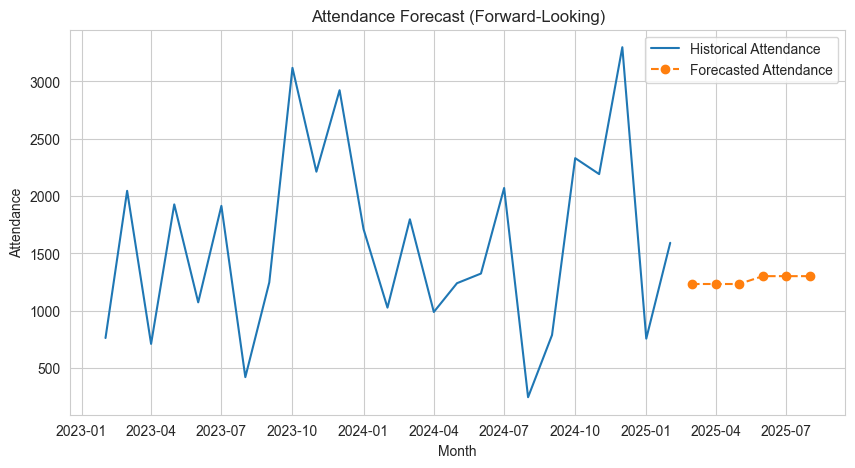

In [113]:
# Forecast Attendance
last_month = df['month'].max()
future_months = pd.date_range(start=last_month + pd.offsets.MonthBegin(1),periods=6,freq='MS')

df_future = pd.DataFrame({'month': future_months})

df_future['event_count'] = df['event_count'].mean()
df_future['weekend_events'] = df['weekend_events'].mean()
df_future['first_time_ratio'] = df['first_time_ratio'].mean()
df_future['patron_retention'] = df['patron_retention'].mean()
df_future['season'] = df_future['month'].dt.month % 12 // 3 + 1
df_future['attendance_lag1'] = df['total_attendance'].iloc[-1]


future_X = df_future[X.columns]
df_future['predicted_attendance'] = rf_attendance.predict(future_X)

plt.figure(figsize=(10,5))

plt.plot(df['month'], df['total_attendance'], label='Historical Attendance')
plt.plot( df_future['month'], df_future['predicted_attendance'], linestyle='--',marker='o',label='Forecasted Attendance')

plt.xlabel("Month")
plt.ylabel("Attendance")
plt.title("Attendance Forecast (Forward-Looking)")
plt.legend()
plt.show()

# Strongest PRedictions of high attendance

season                   : 40.3% importance
event_count              : 16.3% importance
first_time_ratio         : 15.3% importance
attendance_lag1          : 12.6% importance
weekend_events           : 7.9% importance
patron_retention         : 7.6% importance


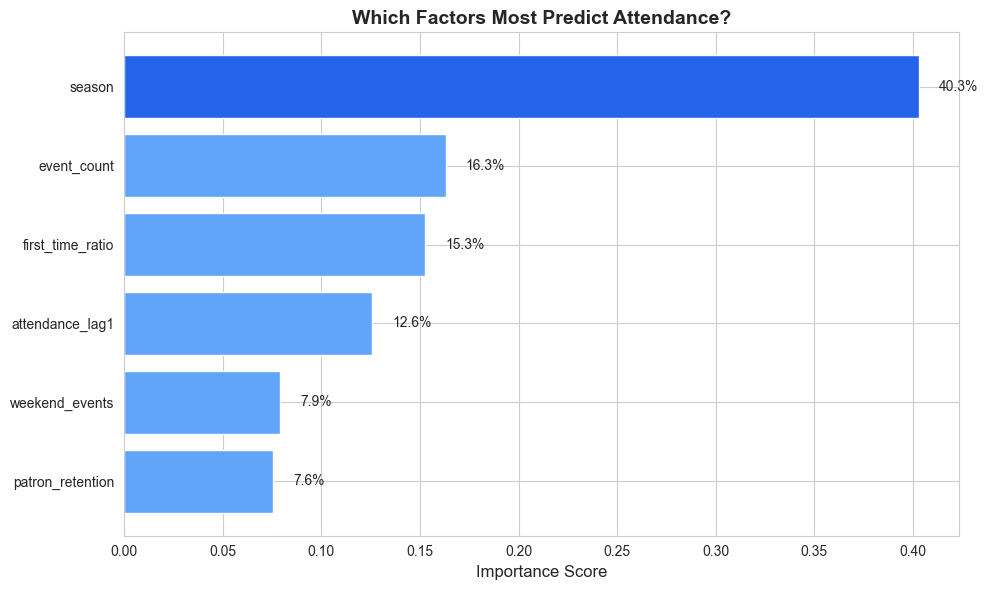

In [92]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_attendance.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:25s}: {row['importance']:.1%} importance")

# Visualize feature importance
plt.figure(figsize=(10, 6))
colors = ['#2563eb' if i == 0 else '#60a5fa' for i in range(len(feature_importance))]
plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Which Factors Most Predict Attendance?', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(feature_importance['importance']):
    plt.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# Revenue 

In [ ]:

sql_donations = """
SELECT 
    DATE_FORMAT(d.date, '%%Y-%%m-01') as month,
    SUM(d.donation_received) as total_donations,
    COUNT(*) as donation_count,
    AVG(d.donation_received) as avg_donation,
    MAX(d.donation_received) as max_donation
FROM donations d
GROUP BY DATE_FORMAT(d.date, '%%Y-%%m-01')
ORDER BY month
"""

df_donations = run_query(sql_donations)

# Convert both to datetime for proper merging
df['month'] = pd.to_datetime(df['month'])
df_donations['month'] = pd.to_datetime(df_donations['month'])

# Merge with attendance data
df_revenue = df.merge(df_donations, on='month', how='inner')

# Add more predictive features
df_revenue['revenue_per_attendee'] = df_revenue['total_donations'] / df_revenue['total_attendance']
df_revenue['donation_lag1'] = df_revenue['total_donations'].shift(1)

# Drop rows with NaN from lag
df_revenue_clean = df_revenue.dropna()

# Prepare ENHANCED revenue model features
X_revenue = df_revenue_clean[[
    'total_attendance', 
    'first_time_ratio', 
    'total_unique_patrons',
    'event_count',
    'weekend_events',
    'donation_lag1'
]]
y_revenue = df_revenue_clean['total_donations']

# Split data (time-series aware)
split_idx = int(len(X_revenue) * 0.8)
X_rev_train = X_revenue.iloc[:split_idx]
X_rev_test = X_revenue.iloc[split_idx:]
y_rev_train = y_revenue.iloc[:split_idx]
y_rev_test = y_revenue.iloc[split_idx:]


# Train revenue model
rf_revenue = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_split=3,
    random_state=42,
    n_jobs=-1
)
rf_revenue.fit(X_rev_train, y_rev_train)

# Predictions
y_rev_pred = rf_revenue.predict(X_rev_test)

# Evaluate
mae_rev = mean_absolute_error(y_rev_test, y_rev_pred)
r2_rev = r2_score(y_rev_test, y_rev_pred)
rmse_rev = np.sqrt(mean_squared_error(y_rev_test, y_rev_pred))

print(f"MAE: ${mae_rev:,.0f}")
print(f"MSE: ${rmse_rev:,.0f}")
print(f"r squared score: {r2_rev:.3f}", end="")


# Calculate revenue per attendee statistics
avg_rev_per_attendee = (df_revenue_clean["total_donations"].sum()/ df_revenue_clean["total_attendance"].sum())

print(f"\nAverage revenue per attendee: ${avg_rev_per_attendee:.2f}")

# Revenue over time
train_range = range(len(y_rev_train))
test_range = range(len(y_rev_train), len(y_rev_train) + len(y_rev_test))

    # Feature importance
rev_importance = pd.DataFrame({
    'feature': X_revenue.columns,
    'importance': rf_revenue.feature_importances_
}).sort_values('importance', ascending=False)

MAE: $22,316
MSE: $26,764
r squared score: -0.324
Average revenue per attendee: $36.10


# Future Forecasting

Next Month Attendance Forecasts:
• Optimistic: 1,658 attendees
• Baseline: 1,658 attendees
• Conservative: 1,652 attendees

Expected Donation Revenue (avg $36.10 per attendee):
• Optimistic: $59,858
• Baseline: $59,858
• Conservative: $59,657

Attendance Confidence Intervals:
• Optimistic: 1,315 to 2,001 attendees
• Baseline: 1,315 to 2,001 attendees
• Conservative: 1,309 to 1,995 attendees


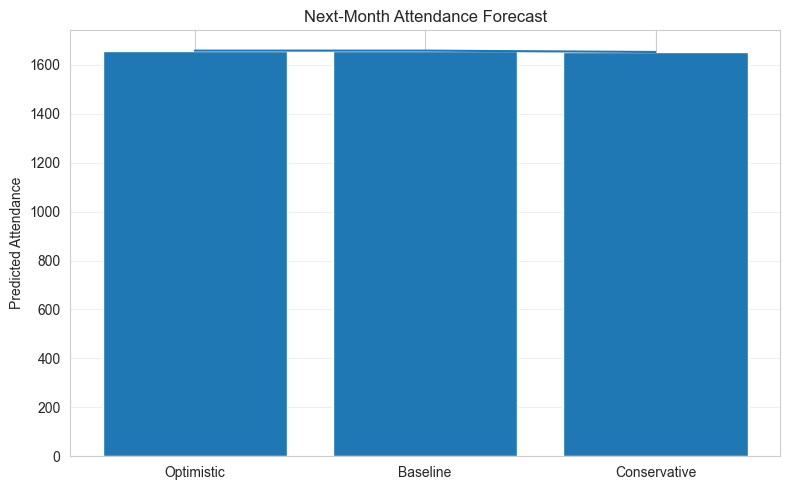

In [117]:
last_attendance = df["total_attendance"].iloc[-1]
scenarios = {
    "Optimistic": {
        "event_count": 18,
        "weekend_events": 10,
        "first_time_ratio": 0.45
    },
    "Baseline": {
        "event_count": 15,
        "weekend_events": 8,
        "first_time_ratio": 0.40
    },
    "Conservative": {
        "event_count": 12,
        "weekend_events": 6,
        "first_time_ratio": 0.35
    }
}

attendance_forecasts = {}

for name, vals in scenarios.items():
    X = pd.DataFrame({
        "event_count": [vals["event_count"]],
        "weekend_events": [vals["weekend_events"]],
        "first_time_ratio": [vals["first_time_ratio"]],
        "patron_retention": [0.62],
        "season": [1],
        "attendance_lag1": [last_attendance]
    })
    
    attendance_forecasts[name] = rf_attendance.predict(X)[0]

print("Next Month Attendance Forecasts:")
for k, v in attendance_forecasts.items():
    print(f"• {k}: {v:,.0f} attendees")

avg_revenue_per_attendee = (
    df_revenue_clean["total_donations"].sum()
    / df_revenue_clean["total_attendance"].sum()
)

print(f"\nExpected Donation Revenue (avg ${avg_revenue_per_attendee:.2f} per attendee):")

revenue_forecasts = {
    k: v * avg_revenue_per_attendee
    for k, v in attendance_forecasts.items()
}

for k, v in revenue_forecasts.items():
    print(f"• {k}: ${v:,.0f}")

print("\nAttendance Confidence Intervals:")
for k, v in attendance_forecasts.items():
    print(f"• {k}: {v - mae:,.0f} to {v + mae:,.0f} attendees")


labels = list(attendance_forecasts.keys())
values = list(attendance_forecasts.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.errorbar(labels, values)

plt.ylabel("Predicted Attendance")
plt.title("Next-Month Attendance Forecast")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

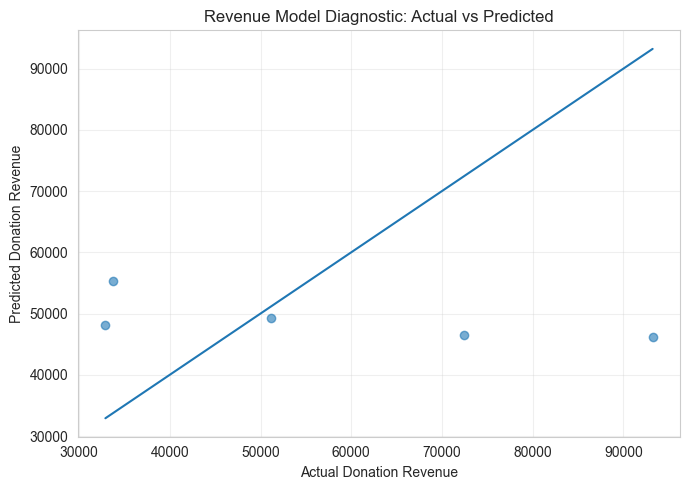

In [ ]:
# Revenue Model Diagnostic (NOT used for forecasting)
# to evaluate predictive validity of revenue model

plt.figure(figsize=(7, 5))
plt.scatter(y_rev_test, y_rev_pred, alpha=0.6)
plt.plot(
    [y_rev_test.min(), y_rev_test.max()],
    [y_rev_test.min(), y_rev_test.max()]
)
plt.xlabel("Actual Donation Revenue")
plt.ylabel("Predicted Donation Revenue")
plt.title("Revenue Model Diagnostic: Actual vs Predicted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The Random Forest revenue model shows weak predictive alignment, with predictions clustering around the mean rather than tracking actual values. Due to low explanatory power (negative R²), this model was rejected for forecasting and revenue was instead estimated using historical average donations per attendee.

In [133]:
output_dir = os.path.join("..", "output_csv")
os.makedirs(output_dir, exist_ok=True)

assert 'feature_importance' in locals(), "feature_importance does not exist"

feature_importance.to_csv(os.path.join(output_dir, "03_attendance_drivers.csv"), index=False)
print("Saved 03_attendance_drivers.csv")

assert 'df' in locals(), "df does not exist"
df.to_csv(os.path.join(output_dir, "03_forecast_data.csv"),index=False)
print("Saved 03_forecast_data.csv")

assert 'df_revenue' in locals(), "df_revenue does not exist"

df_revenue.to_csv(os.path.join(output_dir, "03_revenue_data.csv"),index=False)
print("Saved 03_revenue_data.csv")

assert 'df_future' in locals(), "rev_importance does not exist"

df_future.to_csv(os.path.join(output_dir, "03_attendance_forecast.csv"),index=False)
print("Saved 03_attendance_forecast.csv")


df_att_scenarios = pd.DataFrame(columns=scenarios, data=[attendance_pred])

assert 'df_att_scenarios' in locals(), "df_att_scenarios does not exist"

df_future.to_csv(os.path.join(output_dir, "03_attendance_scenarios.csv"),index=False)
print("Saved 03_attendance_scenarios.csv")

df_revenue_forecast = pd.DataFrame(list(revenue_forecasts.items()), columns=['Scenario', 'Forecasted_Revenue'])

assert 'df_revenue_forecast' in locals(), "df_revenue_forecast does not exist"

df_revenue_forecast.to_csv(os.path.join(output_dir, "03_revenue_forecast.csv"),index=False)
print("Saved 03_revenue_forecast.csv")

Saved 03_attendance_drivers.csv
Saved 03_forecast_data.csv
Saved 03_revenue_data.csv
Saved 03_attendance_forecast.csv
Saved 03_attendance_scenarios.csv
Saved 03_revenue_forecast.csv
